In [38]:
import itertools
import functools
import pathlib
import datetime

import numpy as np
import pandas as pd
import slr.psmsl
import slr.wind
import slr.models
import slr.tables

In [2]:
default_dataset_name = 'rlr_annual'

stations = ['NL', 'NL-Delfzijl', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']
wind_variants = ['NCEP1', '20CR', 'Combined']
model_variants = ['linear', 'quadratic', 'broken_linear', 'broken_quadratic']
quantities = ['height', 'height - surge anomaly']
reference_point_wind = {"lat": 53, "lon": 3}


result_dir = pathlib.Path('../../../data/deltares/results/variants').resolve()


In [3]:
work_df = pd.DataFrame(
    list(
        itertools.product(
            stations, wind_variants, model_variants
        )
    ), 
    columns=['station', 'wind', 'model']
)
work_df

,station,wind,model
0,NL,NCEP1,linear
1,NL,NCEP1,quadratic
2,NL,NCEP1,broken_linear
3,NL,NCEP1,broken_quadratic
4,NL,20CR,linear
...,...,...,...
91,IJmuiden,20CR,broken_quadratic
92,IJmuiden,Combined,linear
93,IJmuiden,Combined,quadratic
94,IJmuiden,Combined,broken_linear


# Stations
Let's first collect all the info of all the stations. We have the main stations and aggregations that are combinations of multiple stations.

In [4]:
# get the zipfiles
zipfiles = slr.psmsl.get_zipfiles()
# get the list of main stations
main_stations = slr.psmsl.get_main_stations()

# get our zipfile
zipfile = zipfiles[default_dataset_name]
# load the stations
stations = slr.psmsl.get_station_list(zipfiles[default_dataset_name], dataset_name=default_dataset_name)

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True, suffixes=['_rws', '_psmsl'])

# these are the individual stations
selected_stations

,name_rws,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,links,lat,lon,name_psmsl,coastline_code,station_code,quality,met_monthly_url,rlr_monthly_url,rlr_annual_url
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,[{'href': 'http://gnss1.tudelft.nl/dpga/statio...,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,[{'href': 'http://geodesy.unr.edu/NGLStationPa...,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,[],52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,[{'href': 'http://geodesy.unr.edu/NGLStationPa...,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,[],53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,[{'href': 'http://gnss1.tudelft.nl/dpga/statio...,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...


# Wind x Stations
Now we can create a dataset with measurements per  (station, wind)  combination. 

In [5]:
stations_with_wind = []
for wind_variant in wind_variants:
    stations = slr.psmsl.add_series_to_stations(selected_stations.copy(), wind_product=wind_variant)
    # aggregate stations (NL + NL - Delfzijl)
    stations = slr.psmsl.add_aggregated_stations(stations)
    stations['wind_variant'] = wind_variant

    stations_with_wind.append(stations)
stations_with_wind_df = pd.concat(stations_with_wind)


found point 52.3799 3.75
found point 53.0 3.0
found point 52.3799 3.75
found point 53.0 3.0
found point 52.3799 3.75
found point 53.0 3.0


# Wind x stations x models



In [6]:
results = []
models = {
    "linear": slr.models.linear_model,
    "broken_linear": slr.models.broken_linear_model,
    "broken_quadratic": slr.models.broken_quadratic_model,
    "quadratic": slr.models.quadratic_model,
}

fits = []
for psmsl_id, station in stations_with_wind_df.iterrows():
    df = station[default_dataset_name]
    for model_variant in model_variants:
        model = models[model_variant]
        for quantity in quantities:
            if 'surge' in quantity:
                with_wind = False
            else:
                with_wind = True
            df = df.query('year >= 1890')
            fit, names = model(df, with_wind=with_wind, quantity=quantity)
            name = station["name"]
            if name == 'NaN' or pd.isna(name):
                name = station['name_rws']
            fits.append({
                "name": name,
                "fit": fit,
                "model": model,
                "names": names,
                "wind_variant": station["wind_variant"],
                "model_variant": model_variant,
                "quantity": quantity,
                "psmsl_id": psmsl_id,
                "series": df
            })
        
 
    

In [7]:
fits_df = slr.tables.fits_to_fits_df(fits)

# Create overview of all stations
Stored in stations.csv

In [8]:
stations_df = stations_with_wind_df.drop(columns=['met_monthly', 'rlr_monthly', 'rlr_annual', 'wind_variant', 'links', 'nulpaal'])
stations_df = stations_df.drop_duplicates()

stations_df.to_csv(result_dir  / 'stations.csv', index_label='psmsl_id')



# Timeseries

In [9]:
dfs = [] 
for psmsl_id, station in stations_with_wind_df.iterrows():
    series_df = station['rlr_annual']
    series_df = series_df.reset_index()
    if 'index' in series_df.columns:
        series_df = series_df.drop(columns=['index'])
    series_df['psmsl_id'] = station['psmsl_id']
    series_df['wind_variant'] = station['wind_variant']
    if 'interpolated' in series_df.columns:
        series_df = series_df.drop(columns=['interpolated', 'flags', 'alpha', 'u', 'v', 'speed', 'direction'])


    dfs.append(series_df)
series_df = pd.concat(dfs)
series_df.to_csv(result_dir  / 'series.csv', index=False)

# Fits
Model parameters. Tabellen met statistiek (trend, std error, p value, AIC) per station, en ook voor de 5 hoofdstations.



In [10]:
def get_fit_columns(row):
    columns = {}
    for name, param in zip(row['names'], row['fit'].params.values):
        columns[name] = param
    for name, p in zip(row['names'], row['fit'].pvalues.values):
        columns['p-' + name] = p
    for name, se in zip(row['names'], row['fit'].bse.values):
        columns['se-' + name] = se
    result = pd.Series(columns)
    return result

extra_columns = fits_df.apply(get_fit_columns, axis=1)
fits_df = pd.merge(fits_df, extra_columns, left_index=True, right_index=True)


In [11]:
drop_columns = [
    'fit', 
    'exog', 
    'prediction', 
    'prediction_mean_tide', 
    'prediction_mean_wind', 
    'prediction_mean_tide_mean_wind', 
    "series",
    "model"
]
fits_df.drop(columns=drop_columns).to_csv(result_dir / 'fits.csv')

# Predicted values

In [12]:
fit = fits_df.query('name == "Delfzijl" and wind_variant == "Combined" and quantity == "height - surge anomaly" and model_variant =="broken_linear"').iloc[0]


fit

name                                                                       Delfzijl
fit                               <statsmodels.regression.linear_model.Regressio...
model                                 <function broken_linear_model at 0x14b9724c0>
names                             [Constant, Trend, +trend (1993), Nodal U, Noda...
wind_variant                                                               Combined
model_variant                                                         broken_linear
quantity                                                     height - surge anomaly
psmsl_id                                                                         24
series                                        year  height interpolated  flags  ...
aic                                                                     1281.312333
F                                                                        231.810176
df_model                                                                    

In [13]:
prediction_dfs = []
for i, fit in fits_df.iterrows():
    pred_int = fit['prediction'].conf_int(obs=True)
    conf_int = fit['prediction'].conf_int(obs=False)
    pred_int_mean_tide = fit['prediction_mean_tide'].conf_int(obs=True)
    conf_int_mean_tide = fit['prediction_mean_tide'].conf_int(obs=False)
    
    prediction_df_i = pd.DataFrame(
        data=dict(
            year=fit['series']['year'],
            psmsl_id=fit['psmsl_id'],
            name=fit['name'],
            # dependent variable
            endog=fit['fit'].model.endog,
            wind_variant=fit['wind_variant'],
            model_variant=fit['model_variant'],
            quantity=fit['quantity'],
            has_tide=fit['has_tide'],
            has_wind=fit['has_wind'],

            prediction=fit['prediction'].predicted_mean, 
            pred_int_lower=pred_int[:, 0],
            pred_int_upper=pred_int[:, 1],
            conf_int_lower=conf_int[:, 0],
            conf_int_upper=conf_int[:, 1],
            prediction_mean_tide=fit['prediction_mean_tide'].predicted_mean, 
            pred_int_mean_tide_lower=pred_int_mean_tide[:, 0],
            pred_int_mean_tide_upper=pred_int_mean_tide[:, 1],
            conf_int_mean_tide_lower=conf_int_mean_tide[:, 0],
            conf_int_mean_tide_upper=conf_int_mean_tide[:, 1]       
        )
    )
    prediction_dfs.append(prediction_df_i)
prediction_df = pd.concat(prediction_dfs)
prediction_df = prediction_df.reset_index(drop=True)





In [14]:
# export the predictions
now = datetime.datetime.now()
name = f'dutch-sea-level-monitor-predictions-{now.year}-{now.month}-{now.day}.csv'
data_dir = pathlib.Path('../../../data/deltares/results')
prediction_df.to_csv(data_dir / name)



In [15]:
prediction_df.query('''\
quantity == "height - surge anomaly" and \
model_variant == "broken_linear" and \
name == "Netherlands (without Delfzijl)" and \
year == 2021
''')



,year,psmsl_id,name,endog,wind_variant,model_variant,quantity,has_tide,has_wind,prediction,pred_int_lower,pred_int_upper,conf_int_lower,conf_int_upper,prediction_mean_tide,pred_int_mean_tide_lower,pred_int_mean_tide_upper,conf_int_mean_tide_lower,conf_int_mean_tide_upper
8183,2021.0,10001,Netherlands (without Delfzijl),90.305726,NCEP1,broken_linear,height - surge anomaly,True,False,93.63042,46.82994,140.430899,83.990839,103.27,81.956147,35.423048,128.489245,73.712001,90.200292
16631,2021.0,10001,Netherlands (without Delfzijl),90.305726,20CR,broken_linear,height - surge anomaly,True,False,93.63042,46.82994,140.430899,83.990839,103.27,81.956147,35.423048,128.489245,73.712001,90.200292
25079,2021.0,10001,Netherlands (without Delfzijl),90.305726,Combined,broken_linear,height - surge anomaly,True,False,93.63042,46.82994,140.430899,83.990839,103.27,81.956147,35.423048,128.489245,73.712001,90.200292


# Create predictions for future
For the selected fit create a prediction for a fifteen years ahead. For this we have to prepare a new array with exogenuous variables. Here we do not use wind because we have surge subtracted. We use mean_tide (not exactly zero over the fitted window).


In [73]:
# select the fit for the 2022 monitor
selected_row = fits_df.query('''\
quantity == "height - surge anomaly" and \
model_variant == "broken_linear" and \
wind_variant == "Combined" and \
name == "Netherlands (without Delfzijl)"
''').iloc[0]
selected_fit = selected_row['fit']

In [74]:
# for which years do we want a prediction
years = np.arange(2021, 2021 + 15 + 1)
# use the same epoch as in slr.models
years_min_epoch = years - 1970
# use the same broken term as in broken_linear_model
broken_term = (years >= 1993) * (years - 1993)
# use the mean nodal u,v
u_mean = np.zeros_like(years) + selected_fit.model.exog[:, 3].mean()
v_mean = np.zeros_like(years) + selected_fit.model.exog[:, 4].mean()
# add a constant (column of ones)
constant = np.ones_like(years)
# concatenate all variables
exog = np.c_[constant, years_min_epoch, broken_term, u_mean, v_mean]
# show mean tide, should be near 0
u_mean[0], v_mean[1]

(-0.0023267029318330807, -0.012616245662740139)

In [75]:
# compute the predictions
next_years_prediction = selected_fit.get_prediction(exog)

In [76]:
# compute the intervals
next_years_pred_int = next_years_prediction.conf_int(obs=True)
next_years_conf_int = next_years_prediction.conf_int(obs=False)

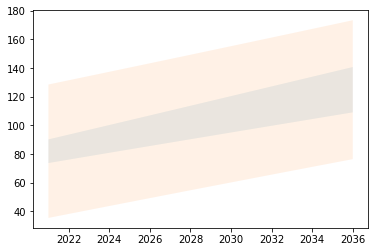

In [77]:

plt.fill_between(years, next_years_conf_int[:, 0], next_years_conf_int[:, 1], alpha=0.1)
plt.fill_between(years, next_years_pred_int[:, 0], next_years_pred_int[:, 1], alpha=0.1)

In [81]:
future_prediction_df = pd.DataFrame(
    data=dict(
        year=years,
        psmsl_id=selected_row['psmsl_id'],
        name=selected_row['name'],
        # dependent variable
        wind_variant=selected_row['wind_variant'],
        model_variant=selected_row['model_variant'],
        quantity=selected_row['quantity'],
        has_tide=selected_row['has_tide'],
        has_wind=selected_row['has_wind'],
        prediction_mean_tide=next_years_prediction.predicted_mean, 
        pred_int_mean_tide_lower=next_years_pred_int[:, 0],
        pred_int_mean_tide_upper=next_years_pred_int[:, 1],
        conf_int_mean_tide_lower=next_years_conf_int[:, 0],
        conf_int_mean_tide_upper=next_years_conf_int[:, 1],
    )
)


<AxesSubplot: xlabel='year'>

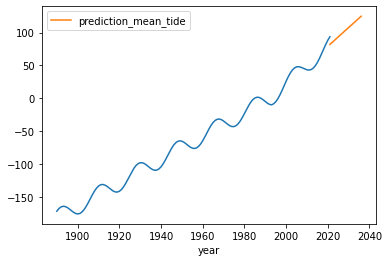

In [99]:
# show results
hindcast = selected_fit.get_prediction().predicted_mean
hindcast_years = selected_fit.model.exog[:, 1] + 1970
fig, ax = plt.subplots()
ax.plot(hindcast_years, hindcast)
future_prediction_df.plot('year', 'prediction_mean_tide', ax=ax)

In [84]:
# write results to new file
now = datetime.datetime.now()
name = f'dutch-sea-level-monitor-future-predictions-{now.year}-{now.month}-{now.day}.csv'
data_dir = pathlib.Path('../../../data/deltares/results')
future_prediction_df.to_csv(data_dir / name)
